# DiploDatos 2020 - Coronavirus en Argentina

## Práctico Aprendizaje no supervizado

In [1]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Clusters

La idea es hacer un clustering de las provincias de acuerdo a cómo fue la progresión de casos de coronavirus en cada una.

Como la información que tenemos son series de tiempo, no podemos aplicar directamene **K-means**, debemos tener en cuenta algunas consideraciones como se explica en el siguiente artículo: https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7d

No se puede utilizar directamente la distancia euclidea para calcular la distancia entre series de tiempo, que además tienen distintas longitudes, para ello utilizaremos un método llamado **Dinamic Time Warping (DTW)**.

Pero primero carguemos los datos con los que vamos a trabajar.

## Data

In [2]:
# Importamos las librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Semilla aleatoria para reproducibilidad
np.random.seed(0)

In [3]:
# Cargamos el CSV en un dataframe directamente desde Github
url = 'https://raw.githubusercontent.com/lucia15/Datos-Covid19-Argentina/master/Argentina-covid19-por-provincia.csv'
data_raw = pd.read_csv(url, error_bad_lines=False)

In [4]:
# Cambiamos el tipo de la columna 'fecha' de object a datetime
data_raw['fecha'] = pd.to_datetime(data_raw['fecha'], format='%Y-%m-%d')

In [5]:
# Obtenemos la cantidad de filas y columnas
print("Cantidad de registros: ", data_raw.shape[0])
print("Cantidad de columnas: ", data_raw.shape[1])

Cantidad de registros:  3933
Cantidad de columnas:  7


In [6]:
data_raw.tail()

,fecha,provincia,casos_total,casos_nuevos,muertes_total,muertes_nuevos,observaciones
3928,2020-09-05,Santa Cruz,2167,138,31.0,0.0,NaN
3929,2020-09-05,Santa Fe,11504,698,88.0,6.0,NaN
3930,2020-09-05,Santiago del Estero,1219,67,307.0,3.0,NaN
3931,2020-09-05,Tierra del Fuego,2296,24,60.0,2.0,NaN
3932,2020-09-05,Tucumán,3692,307,97.0,1.0,NaN


In [7]:
# Nos quedamos con un data frame por provincia
bsas = data_raw[data_raw['provincia']=='Buenos Aires'].reset_index().drop('index', 1)
caba = data_raw[data_raw['provincia']=='CABA'].reset_index().drop('index', 1)
cata = data_raw[data_raw['provincia']=='Catamarca'].reset_index().drop('index', 1)
chaco = data_raw[data_raw['provincia']=='Chaco'].reset_index().drop('index', 1)
chubut = data_raw[data_raw['provincia']=='Chubut'].reset_index().drop('index', 1)
cba = data_raw[data_raw['provincia']=='Córdoba'].reset_index().drop('index', 1)
corr = data_raw[data_raw['provincia']=='Corrientes'].reset_index().drop('index', 1)
entre = data_raw[data_raw['provincia']=='Entre Ríos'].reset_index().drop('index', 1)
jujuy = data_raw[data_raw['provincia']=='Jujuy'].reset_index().drop('index', 1)
formo = data_raw[data_raw['provincia']=='Formosa'].reset_index().drop('index', 1)
pampa = data_raw[data_raw['provincia']=='La Pampa'].reset_index().drop('index', 1)
rioja = data_raw[data_raw['provincia']=='La Rioja'].reset_index().drop('index', 1)
mend = data_raw[data_raw['provincia']=='Mendoza'].reset_index().drop('index', 1)
misio = data_raw[data_raw['provincia']=='Misiones'].reset_index().drop('index', 1)
neuq = data_raw[data_raw['provincia']=='Neuquén'].reset_index().drop('index', 1)
rioneg = data_raw[data_raw['provincia']=='Río Negro'].reset_index().drop('index', 1)
salta = data_raw[data_raw['provincia']=='Salta'].reset_index().drop('index', 1)
sanju = data_raw[data_raw['provincia']=='San Juan'].reset_index().drop('index', 1)
sanlu = data_raw[data_raw['provincia']=='San Luis'].reset_index().drop('index', 1)
stcruz = data_raw[data_raw['provincia']=='Santa Cruz'].reset_index().drop('index', 1)
stfe = data_raw[data_raw['provincia']=='Santa Fe'].reset_index().drop('index', 1)
santia = data_raw[data_raw['provincia']=='Santiago del Estero'].reset_index().drop('index', 1)
tierra = data_raw[data_raw['provincia']=='Tierra del Fuego'].reset_index().drop('index', 1)
tucu = data_raw[data_raw['provincia']=='Tucumán'].reset_index().drop('index', 1)

Para cada provincia tenemos cuatro series de tiempo: **casos_total**, **casos_nuevos**, **muertes_total** y **muertes_nuevos**

In [8]:
bsas.tail()

,fecha,provincia,casos_total,casos_nuevos,muertes_total,muertes_nuevos,observaciones
178,2020-09-01,Buenos Aires,264950,6157,1854.0,177.0,NaN
179,2020-09-02,Buenos Aires,271185,6235,1963.0,109.0,NaN
180,2020-09-03,Buenos Aires,278175,6990,2146.0,183.0,NaN
181,2020-09-04,Buenos Aires,283857,5682,2322.0,176.0,NaN
182,2020-09-05,Buenos Aires,289177,5320,2393.0,71.0,NaN


Por ahora trabajaremos solo con las series de **casos_nuevos**

In [9]:
bsas_new = bsas['casos_nuevos']
caba_new = caba['casos_nuevos']
cata_new = cata['casos_nuevos']
chaco_new = chaco['casos_nuevos']
chubut_new = chubut['casos_nuevos']
cba_new = cba['casos_nuevos']
corr_new = corr['casos_nuevos']
entre_new = entre['casos_nuevos']
formo_new = formo['casos_nuevos']
jujuy_new = jujuy['casos_nuevos']
pampa_new = pampa['casos_nuevos']
rioja_new = rioja['casos_nuevos']
mend_new = mend['casos_nuevos']
misio_new = misio['casos_nuevos']
neuq_new = neuq['casos_nuevos']
rioneg_new = rioneg['casos_nuevos']
salta_new = salta['casos_nuevos']
sanju_new = sanju['casos_nuevos']
sanlu_new = sanlu['casos_nuevos']
stcruz_new = stcruz['casos_nuevos']
stfe_new = stfe['casos_nuevos']
santia_new = santia['casos_nuevos']
tierra_new = tierra['casos_nuevos']
tucu_new = tucu['casos_nuevos']

In [10]:
# Cantidad de días registrados en cada provincia
n0 = len(bsas_new) # Cantidad de días registrados en Buenos Aires
n1 = len(caba_new)
n2 = len(cata_new)
n3 = len(chaco_new)
n4 = len(chubut_new)
n5 = len(cba_new)
n6 = len(corr_new)
n7 = len(entre_new)
n8 = len(formo_new)
n9 = len(jujuy_new)
n10 = len(pampa_new)
n11 = len(rioja_new)
n12 = len(mend_new)
n13 = len(misio_new)
n14 = len(neuq_new)
n15 = len(rioneg_new)
n16 = len(salta_new)
n17 = len(sanju_new)
n18 = len(sanlu_new)
n19 = len(stcruz_new)
n20 = len(stfe_new)
n21 = len(santia_new)
n22 = len(tierra_new)
n23 = len(tucu_new)

Text(0.3, 0.75, 'Tucumán')

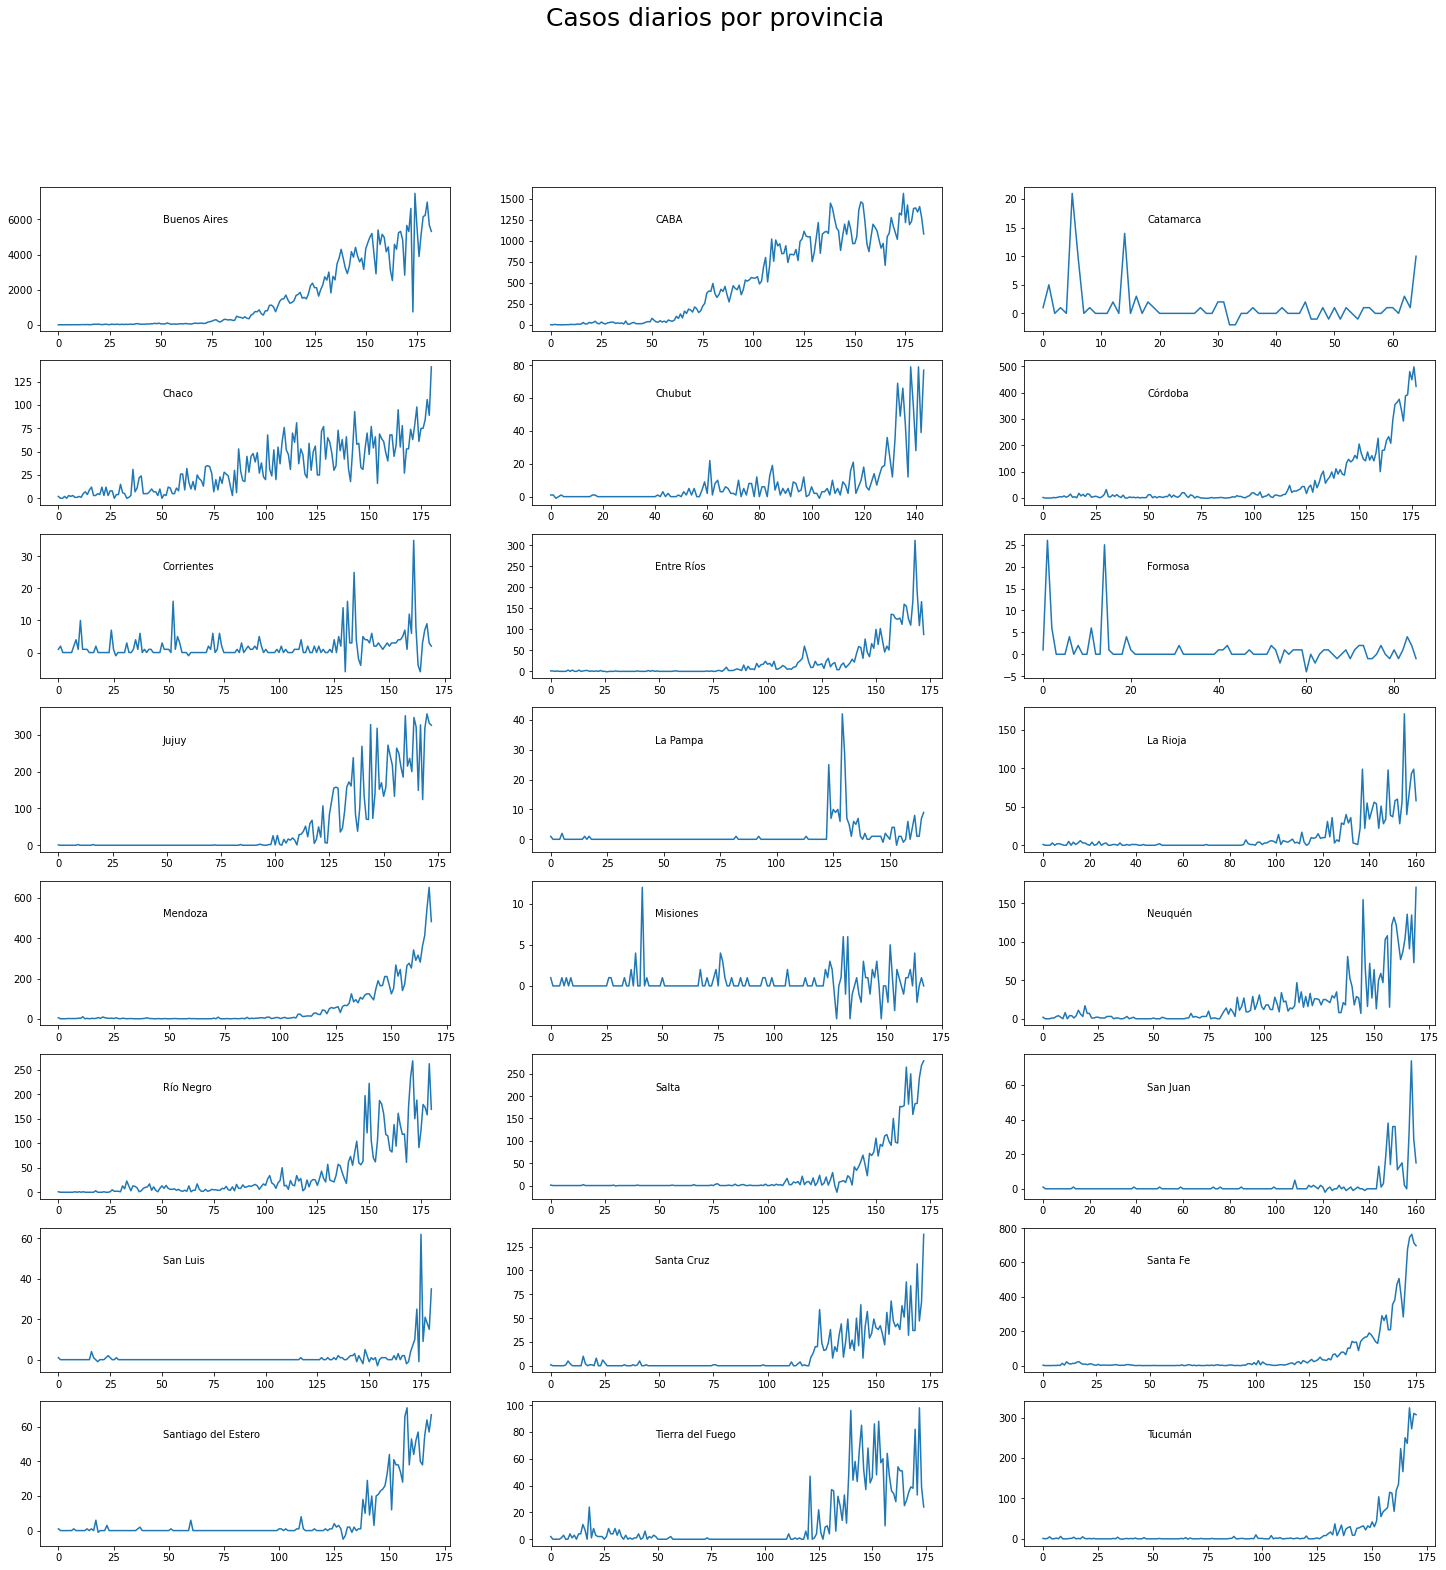

In [11]:
headers = ['Buenos Aires', 'CABA', 'Catamarca', 'Chaco', 'Chubut', 'Córdoba', 'Corrientes',
           'Entre Ríos', 'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones',
           'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe',
           'Santiago del Estero', 'Tierra del Fuego', 'Tucumán']

fig, axs = plt.subplots(8, 3)
fig.set_figheight(25)
fig.set_figwidth(25)
fig.suptitle('Casos diarios por provincia', fontsize=25)
axs[0,0].plot(range(0,n0), bsas_new)
axs[0,0].text(0.3, 0.75, headers[0], transform=axs[0,0].transAxes)
axs[0,1].plot(range(0,n1), caba_new)
axs[0,1].text(0.3, 0.75, headers[1], transform=axs[0,1].transAxes)
axs[0,2].plot(range(0,n2), cata_new)
axs[0,2].text(0.3, 0.75, headers[2], transform=axs[0,2].transAxes)
axs[1,0].plot(range(0,n3), chaco_new)
axs[1,0].text(0.3, 0.75, headers[3], transform=axs[1,0].transAxes)
axs[1,1].plot(range(0,n4), chubut_new)
axs[1,1].text(0.3, 0.75, headers[4], transform=axs[1,1].transAxes)
axs[1,2].plot(range(0,n5), cba_new)
axs[1,2].text(0.3, 0.75, headers[5], transform=axs[1,2].transAxes)
axs[2,0].plot(range(0,n6), corr_new)
axs[2,0].text(0.3, 0.75, headers[6], transform=axs[2,0].transAxes)
axs[2,1].plot(range(0,n7), entre_new)
axs[2,1].text(0.3, 0.75, headers[7], transform=axs[2,1].transAxes)
axs[2,2].plot(range(0,n8), formo_new)
axs[2,2].text(0.3, 0.75, headers[8], transform=axs[2,2].transAxes)
axs[3,0].plot(range(0,n9), jujuy_new)
axs[3,0].text(0.3, 0.75, headers[9], transform=axs[3,0].transAxes)
axs[3,1].plot(range(0,n10), pampa_new)
axs[3,1].text(0.3, 0.75, headers[10], transform=axs[3,1].transAxes)
axs[3,2].plot(range(0,n11), rioja_new)
axs[3,2].text(0.3, 0.75, headers[11], transform=axs[3,2].transAxes)
axs[4,0].plot(range(0,n12), mend_new)
axs[4,0].text(0.3, 0.75, headers[12], transform=axs[4,0].transAxes)
axs[4,1].plot(range(0,n13), misio_new)
axs[4,1].text(0.3, 0.75, headers[13], transform=axs[4,1].transAxes)
axs[4,2].plot(range(0,n14), neuq_new)
axs[4,2].text(0.3, 0.75, headers[14], transform=axs[4,2].transAxes)
axs[5,0].plot(range(0,n15), rioneg_new)
axs[5,0].text(0.3, 0.75, headers[15], transform=axs[5,0].transAxes)
axs[5,1].plot(range(0,n16), salta_new)
axs[5,1].text(0.3, 0.75, headers[16], transform=axs[5,1].transAxes)
axs[5,2].plot(range(0,n17), sanju_new)
axs[5,2].text(0.3, 0.75, headers[17], transform=axs[5,2].transAxes)
axs[6,0].plot(range(0,n18), sanlu_new)
axs[6,0].text(0.3, 0.75, headers[18], transform=axs[6,0].transAxes)
axs[6,1].plot(range(0,n19), stcruz_new)
axs[6,1].text(0.3, 0.75, headers[19], transform=axs[6,1].transAxes)
axs[6,2].plot(range(0,n20), stfe_new)
axs[6,2].text(0.3, 0.75, headers[20], transform=axs[6,2].transAxes)
axs[7,0].plot(range(0,n21), santia_new)
axs[7,0].text(0.3, 0.75, headers[21], transform=axs[7,0].transAxes)
axs[7,1].plot(range(0,n22), tierra_new)
axs[7,1].text(0.3, 0.75, headers[22], transform=axs[7,1].transAxes)
axs[7,2].plot(range(0,n23), tucu_new)
axs[7,2].text(0.3, 0.75, headers[23], transform=axs[7,2].transAxes)

Lo que sigue está inspirado en:

https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3

Leerlo!!!

También será necesario que instalen el paquete **tslearn** (https://github.com/tslearn-team/tslearn)

## Dinamic Time Warping

Dada las series $X=(x_0, ..., x_n)$ y $Y=(y_0, ...,y_m)$, DTW se calcula como la raíz cuadrada de la suma de las distancias al cuadrado entre cada elemento en $X$ y su punto más cercano en $Y$.

Notar que $DTW(X,Y) \neq DTW(Y,X)$

Para comparar dos series de tiempo con DTW, primero sería conveniente escalarlas a un mismo rango, para eso definimos la siguiente función:

In [12]:
from sklearn.preprocessing import MinMaxScaler

def scale(X, ran=(0,1)):
    x = X.values.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=ran)
    xx = scaler.fit_transform(x)
    return xx

In [13]:
from tslearn.metrics import dtw, dtw_path

dtw_score = dtw(scale(cba_new), scale(tucu_new))
dtw_score

0.3527152432599102

La siguiente función imprime, para cada día de Córdoba, el día más parecido de Tucumán, generando un "camino".

In [14]:
dtw_p = dtw_path(scale(cba_new), scale(tucu_new))
dtw_p

([(0, 0),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 2),
  (7, 2),
  (8, 2),
  (9, 2),
  (10, 3),
  (11, 3),
  (12, 3),
  (13, 3),
  (14, 4),
  (14, 5),
  (15, 6),
  (16, 7),
  (17, 8),
  (18, 8),
  (19, 8),
  (20, 8),
  (21, 8),
  (22, 8),
  (23, 9),
  (23, 10),
  (23, 11),
  (23, 12),
  (23, 13),
  (24, 14),
  (25, 14),
  (26, 14),
  (27, 15),
  (27, 16),
  (27, 17),
  (28, 18),
  (29, 18),
  (30, 18),
  (31, 18),
  (32, 18),
  (33, 18),
  (34, 18),
  (35, 18),
  (36, 18),
  (37, 19),
  (37, 20),
  (37, 21),
  (37, 22),
  (37, 23),
  (37, 24),
  (37, 25),
  (37, 26),
  (37, 27),
  (37, 28),
  (37, 29),
  (37, 30),
  (37, 31),
  (37, 32),
  (37, 33),
  (38, 34),
  (39, 35),
  (39, 36),
  (39, 37),
  (39, 38),
  (39, 39),
  (39, 40),
  (40, 41),
  (41, 42),
  (42, 43),
  (42, 44),
  (42, 45),
  (43, 46),
  (44, 47),
  (44, 48),
  (44, 49),
  (44, 50),
  (44, 51),
  (44, 52),
  (44, 53),
  (44, 54),
  (44, 55),
  (44, 56),
  (44, 57),
  (44, 58),
  (44, 59),
  (44, 60),
  (

#### Una variante de DTW: soft-DTW

soft-DTW es una variante diferenciable de DTW que reemplaza la operación *min* no diferenciable con una operación *soft-min* diferenciable:

In [15]:
from tslearn.metrics import soft_dtw

soft_dtw_score = soft_dtw(scale(cba_new), scale(tucu_new), gamma=.1)
soft_dtw_score

-28.822569914871938

soft-DTW depende de un hiperparámetro $\gamma$ que controla el suavizado de la métrica resultante

### Mapa de calor (Heat map)

Este ejemplo ilustra el cálculo DTW entre series de tiempo y traza la ruta de alineación óptima.

La imagen representa la matriz de costos, es decir, la distancia euclidiana al cuadrado para cada punto de tiempo entre ambas series de tiempo, que se representan a la izquierda y en la parte superior de la matriz de costos.

La ruta óptima, que es la ruta que minimiza el costo total para ir desde el primer momento al último, está representada en blanco en la imagen.

In [16]:
from scipy.spatial.distance import cdist

def heat_map(X, Y):
    
    # X and Y must have the same size
    if len(X) > len(Y):
        X = X[-1*len(Y):]
    elif len(X) < len(Y):
        Y = Y[-1*len(X):]
        
    s_y1 = scale(X)
    s_y2 = scale(Y)
    sz = s_y1.shape[0]

    path, sim = dtw_path(s_y1, s_y2)

    plt.figure(1, figsize=(8, 8))

    # definitions for the axes
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02

    rect_s_y = [left, bottom, w_ts, height]
    rect_gram = [left_h, bottom, width, height]
    rect_s_x = [left_h, bottom_h, width, h_ts]

    ax_gram = plt.axes(rect_gram)
    ax_s_x = plt.axes(rect_s_x)
    ax_s_y = plt.axes(rect_s_y)

    mat = cdist(s_y1, s_y2)

    ax_gram.imshow(mat, origin='lower')
    ax_gram.axis("off")
    ax_gram.autoscale(False)
    ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)

    ax_s_x.plot(np.arange(sz), s_y2, "b-", linewidth=3.)
    ax_s_x.axis("off")
    ax_s_x.set_xlim((0, sz - 1))

    ax_s_y.plot(- s_y1, np.arange(sz), "b-", linewidth=3.)
    ax_s_y.axis("off")
    ax_s_y.set_ylim((0, sz - 1))

    plt.tight_layout()
    plt.show()

/home/lucia/.anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


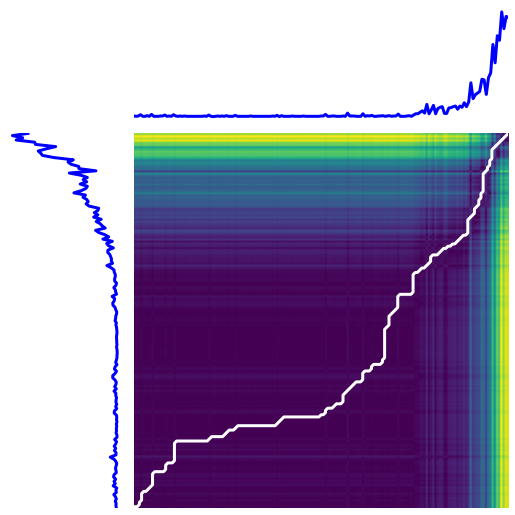

In [17]:
heat_map(cba_new, tucu_new)

### Matriz de distancias

Ahora comparemos las 24 provincias contra las 24 provincias:

In [18]:
provs = [bsas_new, caba_new, cata_new, chaco_new, chubut_new, cba_new, 
        corr_new, entre_new, formo_new, jujuy_new, pampa_new, rioja_new, 
        mend_new, misio_new, neuq_new, rioneg_new, salta_new, sanju_new, 
        sanlu_new, stcruz_new, stfe_new, santia_new, tierra_new, tucu_new]

def distance_matrix(provs, metric="dtw"):

    dist_matrix = np.empty([24, 24])

    for X, i in zip(provs, range(0,24)):
        for Y, j in zip(provs, range(0,24)):
            if metric == "dtw":
                dist_matrix[i][j] = dtw(scale(X), scale(Y))
            if metric == "softdtw":
                dist_matrix[i][j] = soft_dtw(scale(X), scale(Y))

    dist_matrix = pd.DataFrame(dist_matrix, index=headers, columns=headers)
    return dist_matrix

In [19]:
D = distance_matrix(provs)
D

,Buenos Aires,CABA,Catamarca,Chaco,Chubut,Córdoba,Corrientes,Entre Ríos,Formosa,Jujuy,...,Neuquén,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán
Buenos Aires,0.000000,0.914329,1.770200,1.325892,1.069712,0.906061,2.270279,1.205088,2.779174,1.190361,...,1.262906,0.985666,0.995481,1.335360,1.390263,1.045167,0.907482,1.029341,1.402080,1.048712
CABA,0.914329,0.000000,2.331108,1.406940,1.273413,0.776010,2.568367,1.508258,4.286150,1.262916,...,1.267659,1.081759,0.817325,1.901490,1.684511,1.278915,0.929974,0.981124,1.403924,0.932945
Catamarca,1.770200,2.331108,0.000000,1.717489,1.473955,1.779970,1.286518,1.488358,0.682102,2.025087,...,1.327042,1.738133,1.583161,1.242706,1.141757,1.576399,1.768799,1.449158,1.686860,1.735213
Chaco,1.325892,1.406940,1.717489,0.000000,1.334299,1.062659,1.801386,1.340959,2.250964,1.290022,...,1.196272,1.175746,1.134631,1.516748,1.398807,1.046194,1.151246,1.228224,1.612449,1.145494
Chubut,1.069712,1.273413,1.473955,1.334299,0.000000,0.932351,1.864783,1.133143,2.209960,1.157246,...,1.031965,0.976964,0.908065,1.246472,1.098023,0.890299,0.896391,0.938780,1.294354,0.852814
Córdoba,0.906061,0.776010,1.779970,1.062659,0.932351,0.000000,2.374718,1.046405,2.592645,1.209451,...,1.034382,0.923343,0.565368,1.140188,1.144170,0.838245,0.412301,0.742702,1.551467,0.352715
Corrientes,2.270279,2.568367,1.286518,1.801386,1.864783,2.374718,0.000000,1.712298,1.081727,2.478716,...,1.955004,1.990346,2.137776,1.589296,1.509418,1.910643,2.355413,1.965980,1.792286,2.393401
Entre Ríos,1.205088,1.508258,1.488358,1.340959,1.133143,1.046405,1.712298,0.000000,2.107729,1.522143,...,1.212204,0.948283,1.158345,0.597767,0.852826,1.039212,1.054959,1.156427,1.201546,1.057458
Formosa,2.779174,4.286150,0.682102,2.250964,2.209960,2.592645,1.081727,2.107729,0.000000,3.148514,...,2.325897,2.640745,2.518418,1.867656,1.641018,2.098573,2.506550,2.540945,2.488028,2.462163
Jujuy,1.190361,1.262916,2.025087,1.290022,1.157246,1.209451,2.478716,1.522143,3.148514,0.000000,...,1.123715,1.083044,1.199354,1.769717,1.506179,1.140732,1.248803,1.229634,1.414868,1.232925


Notar que las matrices son simétricas, ¿significa esto que para este conjunto de datos si se cumple $DTW(X,Y) = DTW(Y,X)$?

Imprimimos para cada provincia la provincia más "próxima"

In [20]:
D[D>.01].idxmin()

Buenos Aires                       Córdoba
CABA                               Córdoba
Catamarca                          Formosa
Chaco                           Santa Cruz
Chubut                             Tucumán
Córdoba                            Tucumán
Corrientes                         Formosa
Entre Ríos                        San Juan
Formosa                          Catamarca
Jujuy                            Río Negro
La Pampa                         Catamarca
La Rioja                          San Juan
Mendoza                           Santa Fe
Misiones                           Formosa
Neuquén                         Santa Cruz
Río Negro                          Córdoba
Salta                  Santiago del Estero
San Juan                          La Rioja
San Luis                          San Juan
Santa Cruz                        Santa Fe
Santa Fe                           Mendoza
Santiago del Estero                  Salta
Tierra del Fuego                 Río Negro
Tucumán    

Notar que acá ya no hay simetría

In [21]:
# TO DO:
# Probar con metric="softdtw" e interpretar los resultados

### Entrenando un modelo

Primero necesitamos poner los datos en el formato correcto

In [22]:
from tslearn.utils import to_time_series_dataset

data = to_time_series_dataset(provs)

Y preprocesarlos para que cada serie tenga media 0 y varianza 1

In [23]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

data = TimeSeriesScalerMeanVariance().fit_transform(data)

También se pueden acortar las series (opcional) de ser necesario

In [24]:
#from tslearn.preprocessing import TimeSeriesResampler

#data = TimeSeriesResampler(sz=100).fit_transform(data)

### K-means Clustering con Dynamic Time Warping

In [25]:
from tslearn.clustering import TimeSeriesKMeans

k = 4

model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
labels = model.fit_predict(data)
print(labels)

/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


[3 3 2 3 0 0 1 0 2 0 2 1 0 2 0 0 0 1 1 0 0 0 3 0]


### Visualización

Grafica las series de cada cluster, la serie roja es el "centroide".

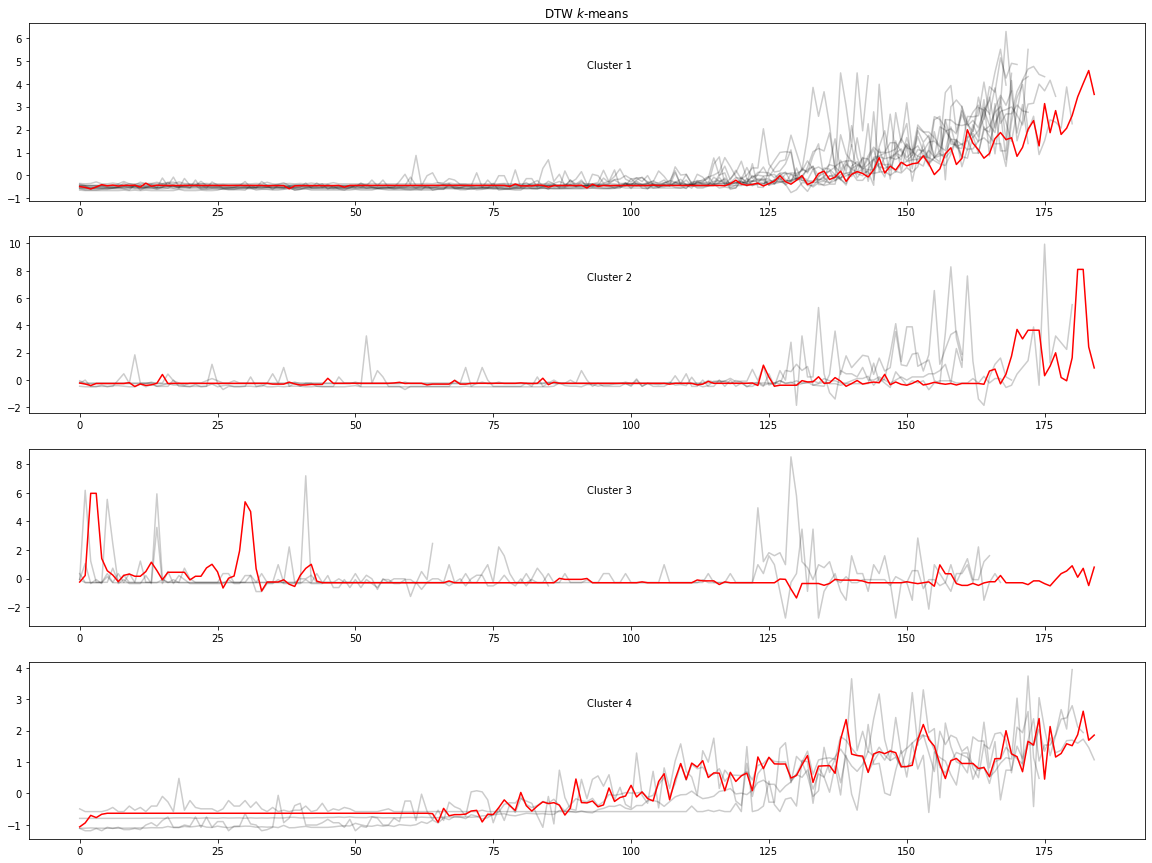

In [26]:
fig, axs = plt.subplots(k, figsize=(20, 15))

for i in range(k):
    
    for X in data[labels == i]:        
        axs[i].plot(X.ravel(), "k-", alpha=.2)
    
    axs[i].plot(model.cluster_centers_[i].ravel(), "r-")
    axs[i].text(0.5, 0.75, 'Cluster %d' % (i + 1), transform=axs[i].transAxes)
    if i == 0:
        axs[i].title.set_text("DTW $k$-means")

In [27]:
for i in range(0,k):
    print('---------------------------------')
    print('Cluster %d' % (i+1))
    print('---------------------------------')
    for p, j in zip(headers, labels):
        if j == i : print(p)

---------------------------------
Cluster 1
---------------------------------
Chubut
Córdoba
Entre Ríos
Jujuy
Mendoza
Neuquén
Río Negro
Salta
Santa Cruz
Santa Fe
Santiago del Estero
Tucumán
---------------------------------
Cluster 2
---------------------------------
Corrientes
La Rioja
San Juan
San Luis
---------------------------------
Cluster 3
---------------------------------
Catamarca
Formosa
La Pampa
Misiones
---------------------------------
Cluster 4
---------------------------------
Buenos Aires
CABA
Chaco
Tierra del Fuego


### Evaluación del modelo

Si no se conocen las verdaderas etiquetas, la evaluación debe realizarse utilizando el propio modelo. El coeficiente **silhouette_score** ([sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)) es un ejemplo de tal evaluación, un valor del coeficiente más alto se relaciona con un modelo con clústeres mejor definidos. 

Este coeficiente se define para cada muestra y se compone de dos puntuaciones:

* **a**: La distancia media entre una muestra y todos los demás puntos de la misma clase.

* **b**: La distancia media entre una muestra y todos los demás puntos del siguiente cluster más cercano.

El coeficiente **silhouette_score** $s$ para una sola muestra se define como:

$$ s = \dfrac{b-a}{max(a,b)}$$

Y mide qué tan bien está agrupada una observación.

El coeficiente para un conjunto de muestras se define como el promedio del coeficiente para cada muestra y estima la distancia media entre clusters.

El obetivo es encontrar el número óptimo de clústeres que produzcan una subdivisión del conjunto de datos en bloques densos que estén bien separados entre sí.

+ El valor de $s$ se mueve entre $-1$ para agrupaciones incorrectas y $+1$ para agrupaciones muy densas. Las puntuaciones alrededor de $0$ indican clusters superpuestos. 
+ La puntuación es más alta cuando los clusters son densos y están bien separados. Los valores negativos generalmente indican que se ha asignado una observación al grupo incorrecto.

In [28]:
from tslearn.clustering import silhouette_score

silhouette_score(data, labels, metric="dtw")

0.20240139743081434

In [29]:
#TO DO:
#probar con otros hiperparámetros

### Encontrar el K óptimo

Existen 3 maneras (como se explica en este artículo: https://medium.com/towards-artificial-intelligence/get-the-optimal-k-in-k-means-clustering-d45b5b8a4315)

1. El método del codo (Elbow method)
2. El método Silhouette (Silhouette method)
3. El método de la brecha estadística (Gap Statistic Method)

Solo veremos los dos primeros (pero si tienen ganas de investigar/ implementar el otro lo pueden hacer).

#### Elbow method

Identifica el número $k$ de conglomerados basándose en el supuesto de que el número óptimo debe producir una pequeña inercia (variación total dentro del conglomerado *total intra-cluster variation*). Debe haber un trade-off entre la inercia y el número de clusters. 

Con este concepto, debemos elegir un número $k$ de clusters de forma que agregar otro clúster no mejore mucho.

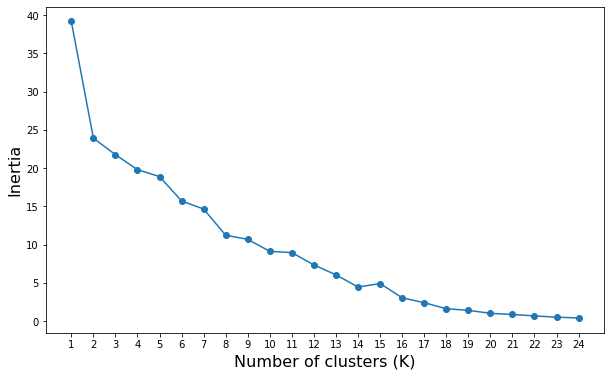

In [30]:
inertia = {}
for k in range(1, 25):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10).fit(data)
    inertia[k] = kmeans.inertia_ 

plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
plt.xlabel("Number of clusters (K)", fontsize=16)
plt.ylabel("Inertia", fontsize=16)
plt.xticks(list(inertia.keys()))
plt.show()

#### Silhouette method

In [31]:
def fit_and_predict(data, k):
    """
    Function to fit and predict the K-means clustering
    """   
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
    y_pred = km.fit_predict(data)
    
    return y_pred, km

In [32]:
sil_scor = {}
for k in range(2, 24):
    cluster_pred, km_model = fit_and_predict(data, k)
    silhouette_avg = silhouette_score(data, cluster_pred, metric="dtw")
    print('For n_clusters k = {0:d}, the silhouette score is {1:.4f}'.format(k, silhouette_avg))
    sil_scor[k] = silhouette_avg

For n_clusters k = 2, the silhouette score is 0.1538
For n_clusters k = 3, the silhouette score is 0.2908
For n_clusters k = 4, the silhouette score is 0.1838
For n_clusters k = 5, the silhouette score is 0.1338
For n_clusters k = 6, the silhouette score is 0.1445
For n_clusters k = 7, the silhouette score is 0.1148
For n_clusters k = 8, the silhouette score is 0.1029
For n_clusters k = 9, the silhouette score is 0.1188
For n_clusters k = 10, the silhouette score is 0.1205
For n_clusters k = 11, the silhouette score is 0.1109
For n_clusters k = 12, the silhouette score is 0.1184
For n_clusters k = 13, the silhouette score is 0.1051
For n_clusters k = 14, the silhouette score is 0.0680
For n_clusters k = 15, the silhouette score is 0.1140
For n_clusters k = 16, the silhouette score is 0.0929
For n_clusters k = 17, the silhouette score is 0.0882
For n_clusters k = 18, the silhouette score is 0.1027
For n_clusters k = 19, the silhouette score is 0.0730
For n_clusters k = 20, the silhouett

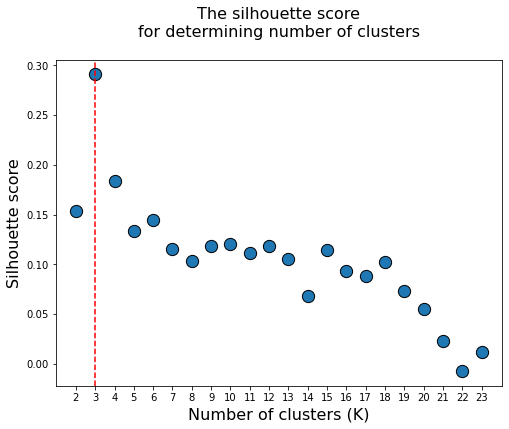

In [33]:
plt.figure(figsize=(8, 6))
plt.title("The silhouette score\nfor determining number of clusters\n", fontsize=16)
plt.scatter(list(sil_scor.keys()), list(sil_scor.values()), marker='o', s=150, edgecolor='k')
plt.xlabel("Number of clusters (K)", fontsize=16)
plt.ylabel("Silhouette score", fontsize=16)
plt.xticks(list(sil_scor.keys()))
plt.axvline(x=max(sil_scor, key=sil_scor.get), color="red", linestyle="--")
plt.show();

¿Qué número de clusters k les parece más conveniente utilizar y por qué?